In [1]:
from pathlib import Path
from typing import Optional

import plotly.express as px
import plotly.graph_objects as go
import polars as pl

from plotly.subplots import make_subplots
from result import Result

from raft.services.renav import read_cameras, clean_camera_dataframe
from raft.utils.log import logger

In [2]:
INPUT_DIR: Path = Path("/media/martin/hdd_01/acfr_revisits_processed")
OUTPUT_DIR: Path = Path("/home/martin/hdd_01/acfr_revisits_processed")

camera_paths: dict = dict()
camera_paths["renav"]: Path = INPUT_DIR / Path(
    "acfr_renav_cameras/r29mrd5h_20090612_225306_cameras.csv"
)
camera_paths["squidle"]: Path = INPUT_DIR / Path(
    "acfr_squidle_cameras/r29mrd5h_20090612_225306_cameras.csv"
)
output_path: Path = OUTPUT_DIR / Path(
    "acfr_cameras_squidle_updated/r29mrd5h_20090612_225306_cameras.csv"
)

for key in ["renav", "squidle"]:
    if not camera_paths[key].exists():
        logger.error(f"file does not exist: {camera_paths[key]}")

In [3]:
cameras: dict = dict()
cameras["renav"]: pl.DataFrame = read_cameras(camera_paths["renav"]).unwrap()
cameras["renav"]: pl.DataFrame = clean_camera_dataframe(cameras["renav"])

cameras["squidle"]: pl.DataFrame = pl.read_csv(camera_paths["squidle"])

figs: dict = dict()

logger.info(cameras["renav"].head())
logger.info(cameras["squidle"].head())

2024-06-04 10:25:26.458 | INFO     | __main__:<module>:9 - shape: (5, 14)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ stereo_le ┆ stereo_ri ┆ timestamp ┆ latitude  ┆ … ┆ altitude ┆ bounding_ ┆ stereo_le ┆ stereo_ri │
│ ft_label  ┆ ght_label ┆ ---       ┆ ---       ┆   ┆ ---      ┆ radius    ┆ ft_image_ ┆ ght_image │
│ ---       ┆ ---       ┆ f64       ┆ f64       ┆   ┆ f32      ┆ ---       ┆ name      ┆ _name     │
│ str       ┆ str       ┆           ┆           ┆   ┆          ┆ f32       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆           ┆   ┆          ┆           ┆ str       ┆ str       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ PR_200906 ┆ PR_200906 ┆ 1.2448e9  ┆ 148.34198 ┆ … ┆ 3.977    ┆ 1.681996  ┆ PR_200906 ┆ PR_200906 │
│ 12_225915 ┆ 12_225915 ┆           ┆ 4         ┆   ┆          ┆           ┆ 12_225915 ┆ 12_225915 │
│ _886_LC16 ┆ _88

In [4]:
# TODO: Overwrite latitude / longitude values in renav where renav.label == squidle.key
cam_r: pl.DataFrame = cameras["renav"]

# Filter squidle cameras that are not among the renav cameras
cameras["filtered"]: pl.DataFrame = cameras["squidle"].filter(
    pl.col("key").is_in(cameras["renav"]["stereo_left_label"])
)

if cameras["filtered"].shape != cameras["renav"].shape:
    logger.error(
        f"number of cameras filtered from Squidle does not match the number of cameras from Renav"
    )

# Sort cameras by label
cameras["filtered"] = cameras["filtered"].sort("key")
cameras["renav"] = cameras["renav"].sort("stereo_left_label")


# Replace lat/lon in Renav cameras with Squidle cameras
cameras["updated"]: pl.DataFrame = cameras["renav"].with_columns(
    [
        cameras["filtered"]["pose.lat"].alias("latitude"),
        cameras["filtered"]["pose.lon"].alias("longitude"),
    ]
)

### Define plot functions

In [5]:
def plot_attitudes(cameras: pl.DataFrame, show: bool = True) -> None:
    """TODO"""
    fig = make_subplots(rows=3, cols=1, subplot_titles=("Roll", "Pitch", "Heading"))

    fig.append_trace(
        go.Scatter(
            x=cameras["timestamp"],
            y=cameras["pitch"],
        ),
        row=1,
        col=1,
    )
    fig.append_trace(
        go.Scatter(
            x=cameras["timestamp"],
            y=cameras["roll"],
        ),
        row=2,
        col=1,
    )
    fig.append_trace(
        go.Scatter(
            x=cameras["timestamp"],
            y=cameras["heading"],
        ),
        row=3,
        col=1,
    )

    fig.update_layout(height=600, width=1000, title_text="Stacked Subplots")
    if show:
        fig.show()

    return fig


def plot_vertical(cameras: pl.DataFrame, show: bool = True) -> None:
    """TODO"""
    fig = make_subplots(rows=3, cols=1, subplot_titles=("Depth", "Height", "Altitude"))

    fig.append_trace(
        go.Scatter(
            x=cameras["timestamp"],
            y=cameras["depth"],
        ),
        row=1,
        col=1,
    )
    fig.append_trace(
        go.Scatter(
            x=cameras["timestamp"],
            y=cameras["height"],
        ),
        row=2,
        col=1,
    )
    fig.append_trace(
        go.Scatter(
            x=cameras["timestamp"],
            y=cameras["altitude"],
        ),
        row=3,
        col=1,
    )

    fig.update_layout(height=600, width=1000, title_text="Stacked Subplots")
    if show:
        fig.show()

    return fig


def plot_geolocations(cameras: pl.DataFrame, show: bool = True) -> None:
    """TODO"""
    fig = px.scatter_mapbox(
        cameras,
        lat="latitude",
        lon="longitude",
        color="timestamp",
        size_max=15,
        zoom=17,
        height=600,
        hover_data={"heading", "stereo_left_label", "depth"},
    )

    fig.update_layout(height=500, width=1000, mapbox_style="open-street-map")
    fig.show()
    return fig

### Plot attitude and vertical timeseries, and geolocations

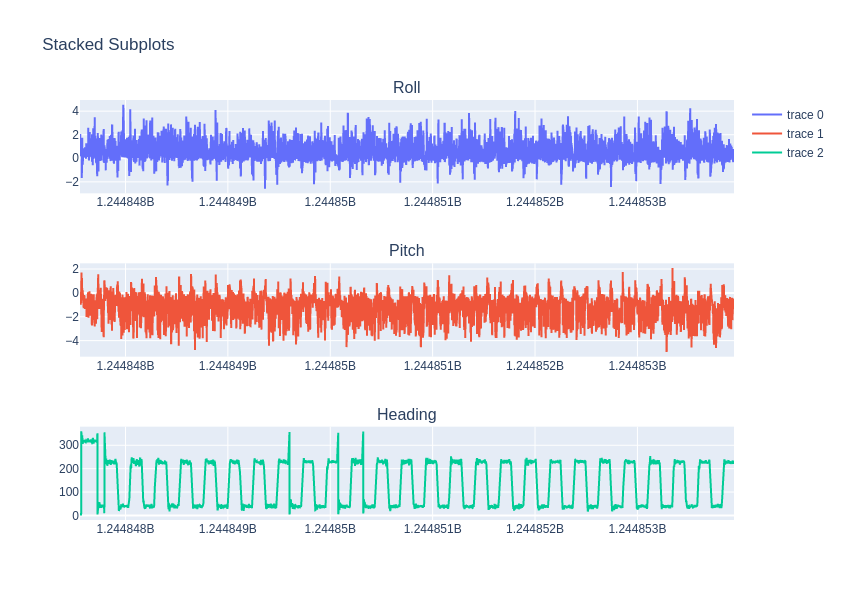

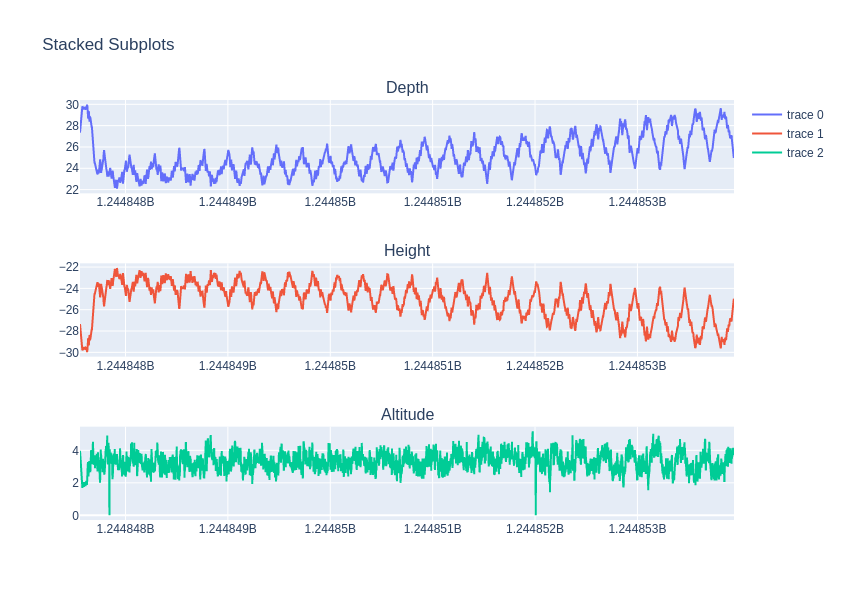

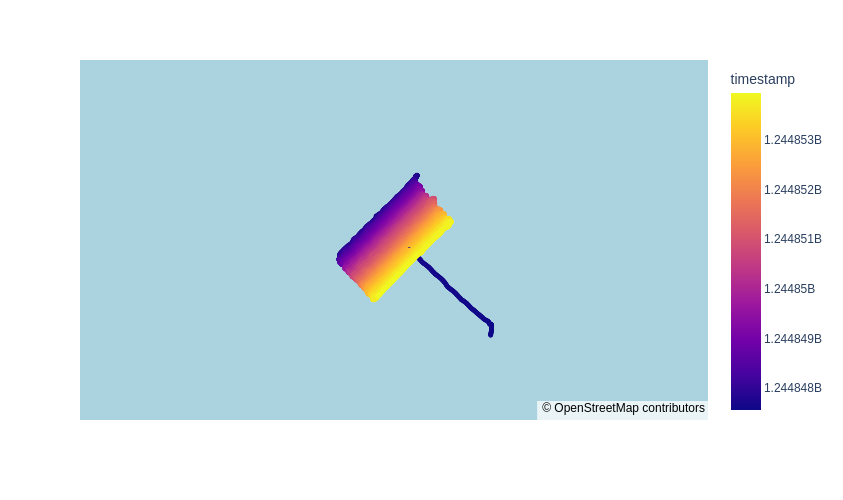

In [6]:
figs["renav_attitudes"] = plot_attitudes(cameras["updated"])
figs["vertical"] = plot_vertical(cameras["updated"])
figs["updated"] = plot_geolocations(cameras["updated"])

### Write updated cameras to file

In [9]:
do_export: bool = False
if do_export:
    error: Optional[str] = cameras["updated"].write_csv(output_path)
    if error:
        logger.error(error)
    else:
        logger.info(f"saved file to: {output_path}")